In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# File processing

from glob import glob
import json
from PIL import Image
from tqdm import tqdm



from collections import defaultdict
from sklearn.model_selection import train_test_split


import matplotlib.image as mpimg

%matplotlib inline



import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU

In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
print(smp.__version__)

0.3.3


**EDA and Dataset preperation**

Read the Data

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
chemin_du_fichier =   '/content/drive/MyDrive/kvasir-seg (2)/'

Mounted at /content/drive


afficher les différentes directory dans cette dataset

In [5]:
fichiers_images = os.listdir(chemin_du_fichier)
print(fichiers_images)

['images', 'masks', 'renamed_bboxes.json']


In [6]:
# Chemin du dossier "images"
chemin_images = os.path.join(chemin_du_fichier, 'images')
# Lister tous les fichiers d'images dans le dossier "images"
fichiers_images = os.listdir(chemin_images)
print(fichiers_images)
len(fichiers_images)


['colonoscopy_0001.jpg', 'colonoscopy_0002.jpg', 'colonoscopy_0003.jpg', 'colonoscopy_0004.jpg', 'colonoscopy_0005.jpg', 'colonoscopy_0006.jpg', 'colonoscopy_0007.jpg', 'colonoscopy_0008.jpg', 'colonoscopy_0009.jpg', 'colonoscopy_0010.jpg', 'colonoscopy_0011.jpg', 'colonoscopy_0012.jpg', 'colonoscopy_0013.jpg', 'colonoscopy_0014.jpg', 'colonoscopy_0015.jpg', 'colonoscopy_0016.jpg', 'colonoscopy_0017.jpg', 'colonoscopy_0018.jpg', 'colonoscopy_0019.jpg', 'colonoscopy_0020.jpg', 'colonoscopy_0021.jpg', 'colonoscopy_0022.jpg', 'colonoscopy_0023.jpg', 'colonoscopy_0024.jpg', 'colonoscopy_0025.jpg', 'colonoscopy_0026.jpg', 'colonoscopy_0027.jpg', 'colonoscopy_0028.jpg', 'colonoscopy_0029.jpg', 'colonoscopy_0030.jpg', 'colonoscopy_0031.jpg', 'colonoscopy_0032.jpg', 'colonoscopy_0033.jpg', 'colonoscopy_0034.jpg', 'colonoscopy_0035.jpg', 'colonoscopy_0036.jpg', 'colonoscopy_0037.jpg', 'colonoscopy_0038.jpg', 'colonoscopy_0039.jpg', 'colonoscopy_0040.jpg', 'colonoscopy_0041.jpg', 'colonoscopy_00

1000

In [7]:
# Chemin du dossier "masks"
chemin_masks = os.path.join(chemin_du_fichier, 'masks')
# Lister tous les fichiers d'images dans le dossier "images"
fichiers_masks = os.listdir(chemin_masks)
print(fichiers_masks)
len(fichiers_masks)


['mask_0001.jpg', 'mask_0002.jpg', 'mask_0003.jpg', 'mask_0004.jpg', 'mask_0005.jpg', 'mask_0006.jpg', 'mask_0007.jpg', 'mask_0008.jpg', 'mask_0009.jpg', 'mask_0010.jpg', 'mask_0011.jpg', 'mask_0012.jpg', 'mask_0013.jpg', 'mask_0014.jpg', 'mask_0015.jpg', 'mask_0016.jpg', 'mask_0017.jpg', 'mask_0018.jpg', 'mask_0019.jpg', 'mask_0020.jpg', 'mask_0021.jpg', 'mask_0022.jpg', 'mask_0023.jpg', 'mask_0024.jpg', 'mask_0025.jpg', 'mask_0026.jpg', 'mask_0027.jpg', 'mask_0028.jpg', 'mask_0029.jpg', 'mask_0030.jpg', 'mask_0031.jpg', 'mask_0032.jpg', 'mask_0033.jpg', 'mask_0034.jpg', 'mask_0035.jpg', 'mask_0036.jpg', 'mask_0037.jpg', 'mask_0038.jpg', 'mask_0039.jpg', 'mask_0040.jpg', 'mask_0041.jpg', 'mask_0042.jpg', 'mask_0043.jpg', 'mask_0044.jpg', 'mask_0045.jpg', 'mask_0046.jpg', 'mask_0047.jpg', 'mask_0048.jpg', 'mask_0049.jpg', 'mask_0050.jpg', 'mask_0051.jpg', 'mask_0052.jpg', 'mask_0053.jpg', 'mask_0054.jpg', 'mask_0055.jpg', 'mask_0056.jpg', 'mask_0057.jpg', 'mask_0058.jpg', 'mask_0059.jp

1000

In [8]:
# Check the file format of each image file in the images folder
images_formats = set()
for file_name in os.listdir(chemin_images):
    file_path = os.path.join(chemin_images, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        images_formats.add(file_format)

# Check the file format of each image file in the masks folder
masks_formats = set()
for file_name in os.listdir(chemin_masks):
    file_path = os.path.join(chemin_masks, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        masks_formats.add(file_format)

# Print the number of images and masks, along with their file formats
print(f"There are {len(fichiers_images)} colonoscopic images with {images_formats} format")
print(f"There are {len(fichiers_masks)} segmentation masked images with {masks_formats} format")


There are 1000 colonoscopic images with {'jpg'} format
There are 1000 segmentation masked images with {'jpg'} format


In [ ]:
# Function to load and normalize images
def load_and_normalize_images(directory):
    normalized_images = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            # Load image
            img = cv2.imread(file_path, cv2.IMREAD_COLOR)
            # Normalize image
            img_normalized = img / 255.0
            normalized_images.append(img_normalized)
    return normalized_images

# Normalize images from the "images" directory
normalized_images = load_and_normalize_images(chemin_images)

# Normalize images from the "masks" directory
normalized_masks = load_and_normalize_images(chemin_masks)

Rename files

In [9]:
#The original file names for both images and masks are the same, this will cause confussion in the future. Let's rename them.

# Define a dictionary to map the original filenames to new filenames
name_mapping = {"images": "colonoscopy_", "masks": "mask_"}

# Rename the files in the "images" subdirectory
for i, file_name in enumerate(fichiers_images):
    old_file_path = os.path.join(chemin_images, file_name)
    new_file_name = f"{name_mapping['images']}{i+1:04d}.jpg"
    new_file_path = os.path.join(chemin_images, new_file_name)
    os.rename(old_file_path, new_file_path)

# Rename the files in the "masks" subdirectory
for i, file_name in enumerate(fichiers_masks):
    old_file_path = os.path.join(chemin_masks, file_name)
    new_file_name = f"{name_mapping['masks']}{i+1:04d}.jpg"
    new_file_path = os.path.join(chemin_masks, new_file_name)
    os.rename(old_file_path, new_file_path)


Here's the renamed colonoscopic images

In [10]:
# Renamed image file name
fichiers_images = os.listdir(chemin_images)
fichiers_images[:5]

['colonoscopy_0001.jpg',
 'colonoscopy_0002.jpg',
 'colonoscopy_0003.jpg',
 'colonoscopy_0004.jpg',
 'colonoscopy_0005.jpg']

Here's the renamed masked images

In [11]:
# Renamed image file name
fichiers_masks = os.listdir(chemin_masks)
fichiers_masks[:5]

['mask_0001.jpg',
 'mask_0002.jpg',
 'mask_0003.jpg',
 'mask_0004.jpg',
 'mask_0005.jpg']

In [12]:
# Define the path to the "kavsir_bboxes.json" file


chemin_du_fichier =   '/content/drive/MyDrive/kvasir-seg (2)/'
file_path = os.path.join(chemin_du_fichier, "kavsir_bboxes.json")

# Check if the JSON file exists
if os.path.exists(file_path):
    # Read the JSON file
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    # Create a new dictionary to store the renamed data
    renamed_data = {}

    # Rename the serial numbers in the JSON file
    for i, (file_name, file_data) in enumerate(data.items(), start=1):
        new_file_name = f"colonoscopy_{i:04d}"
        renamed_data[new_file_name] = file_data

    # Save the renamed data to a new JSON file
    renamed_file_path = os.path.join(chemin_du_fichier, "renamed_bboxes.json")
    with open(renamed_file_path, 'w') as json_file:
        json.dump(renamed_data, json_file, indent=4)

    print(f"The JSON file has been renamed and saved to {renamed_file_path}")
else:
    # Print a message indicating that the file does not exist
    print(f"The JSON file {file_path} does not exist")

The JSON file /content/drive/MyDrive/kvasir-seg (2)/kavsir_bboxes.json does not exist


In [13]:
# Define the path to the "renamed_bboxes.jso" file
chemin_du_fichier =   '/content/drive/MyDrive/kvasir-seg (2)/'
file_path = os.path.join(chemin_du_fichier, "renamed_bboxes.json")

# Read the JSON file
with open(file_path, 'r') as json_file:
    json_object = json.load(json_file)

# Print first 5 serials
list(json_object.keys())[:5]

['colonoscopy_0001',
 'colonoscopy_0002',
 'colonoscopy_0003',
 'colonoscopy_0004',
 'colonoscopy_0005']

In [14]:
# Define the path to the "kavsir_bboxes.json" file
old_path = os.path.join(chemin_du_fichier, "kavsir_bboxes.json")

# Check if the file exists
if os.path.exists(old_path):
    # Remove the file if it exists
    os.remove(old_path)
    print(f"{old_path} has been removed")
else:
    # Print a message indicating that the file does not exist
    print(f"{old_path} does not exist")

/content/drive/MyDrive/kvasir-seg (2)/kavsir_bboxes.json does not exist


In [15]:
# Define the path to the "Kvasir-SEG" directory, "images" and "masks" subdirectories, and the JSON file
chemin_du_fichier = "/content/drive/MyDrive/kvasir-seg (2)"
chemin_images = os.path.join(chemin_du_fichier, "images")
chemin_masks = os.path.join(chemin_du_fichier, "masks")
images_json= os.path.join(chemin_du_fichier, "renamed_bboxes.json")

# Get a list of filenames in the "images" and "masks" subdirectories
fichiers_images = os.listdir(chemin_images)
fichiers_masks = os.listdir(chemin_masks)

# Read the JSON file
with open(images_json, 'r') as json_file:
    kavsir_bboxes = json.load(json_file)

In [16]:
# Print the number of images and masks
print(f"There are {len(fichiers_images)} colonoscopic images")
print(f"There are {len(fichiers_masks)} segmentation masked images")
print(f"The JSON file contains the mask coordinates for the {len(list(kavsir_bboxes))} colonoscopic images ")

There are 1000 colonoscopic images
There are 1000 segmentation masked images
The JSON file contains the mask coordinates for the 1000 colonoscopic images 


array([[[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [2, 4, 4],
        [2, 4, 4],
        [2, 4, 4]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [1, 3, 3],
        [1, 3, 3],
        [1, 3, 3]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]]], dtype=uint8)
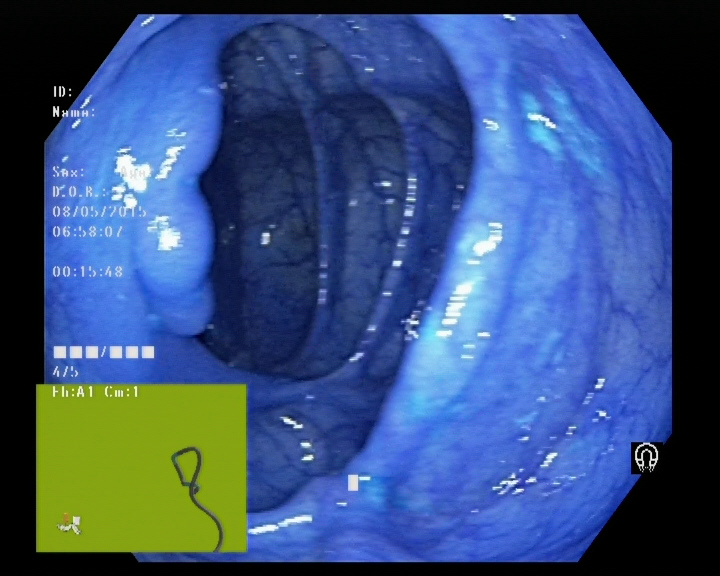

In [17]:
# Read first image from RGB colonoscopic images
cv2.imread(os.path.join(chemin_images,fichiers_images[0]))


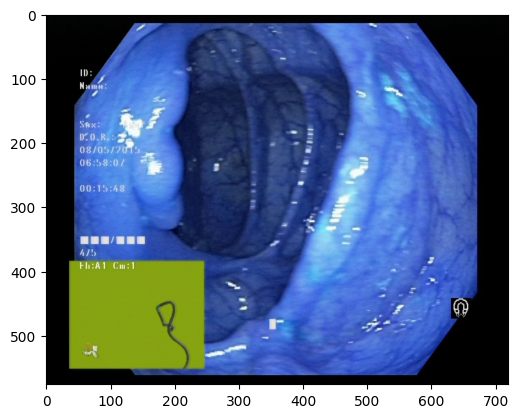

In [18]:

# Read image (BGR by default)
BGR_img1 = cv2.imread(os.path.join(chemin_images,fichiers_images[0]))

# Display image
plt.imshow(BGR_img1, vmin=0, vmax=255)
plt.show()

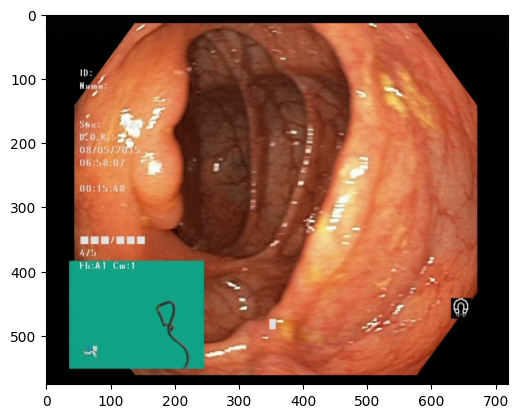

In [19]:
import matplotlib.pyplot as plt
import cv2

# Lire l'image en BGR
BGR_img1 = cv2.imread(os.path.join(chemin_images, fichiers_images[0]))

# Convertir l'image en RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Normaliser les valeurs des pixels à la plage [0, 1]
normalized_img = RGB_img1 / 255.0

# Afficher l'image normalisée
plt.imshow(normalized_img)
plt.show()

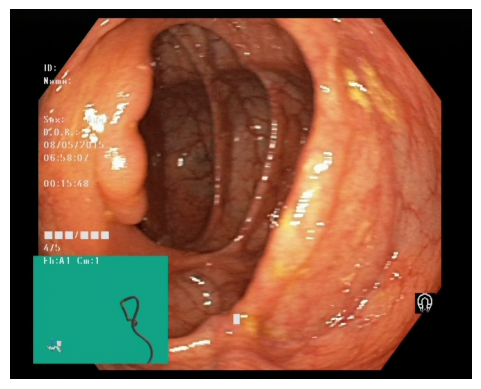

In [20]:
import cv2
import matplotlib.pyplot as plt

# Read image (BGR by default)
BGR_img1 = cv2.imread(os.path.join(chemin_images, fichiers_images[0]))

# Check if the image is loaded successfully
if BGR_img1 is None:
    print("Error: Unable to load the image.")
else:
    # Convert BGR to RGB
    RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

    # Normalize the image
    normalized_img = RGB_img1 / 255.0

    # Display image
    plt.imshow(normalized_img)
    plt.axis('off')  # Turn off axis
    plt.show()

Taille de l'image 1: (576, 720, 3)
Taille de l'image 2: (576, 720, 3)
Taille de l'image 3: (576, 720, 3)
Taille de l'image 4: (576, 720, 3)
Taille de l'image 5: (576, 720, 3)
Taille de l'image 6: (576, 720, 3)
Taille de l'image 7: (576, 720, 3)
Taille de l'image 8: (576, 720, 3)
Taille de l'image 9: (576, 720, 3)
Taille de l'image 10: (576, 720, 3)
Taille de l'image 11: (576, 720, 3)
Taille de l'image 12: (1072, 1920, 3)
Taille de l'image 13: (576, 720, 3)
Taille de l'image 14: (576, 720, 3)
Taille de l'image 15: (529, 622, 3)
Taille de l'image 16: (1070, 1348, 3)
Taille de l'image 17: (529, 619, 3)
Taille de l'image 18: (528, 622, 3)
Taille de l'image 19: (528, 617, 3)
Taille de l'image 20: (547, 626, 3)
Taille de l'image 21: (530, 621, 3)
Taille de l'image 22: (1019, 1214, 3)
Taille de l'image 23: (531, 570, 3)
Taille de l'image 24: (530, 622, 3)
Taille de l'image 25: (529, 622, 3)
Taille de l'image 26: (530, 611, 3)
Taille de l'image 27: (546, 626, 3)
Taille de l'image 28: (547, 626

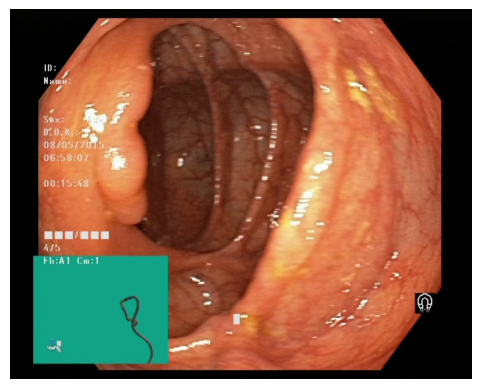

In [21]:
# Fonction pour charger et normaliser les images
def load_and_normalize_images(directory, file_list):
    normalized_images = []
    for file_name in file_list:
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            # Charger l'image (BGR par défaut)
            BGR_img = cv2.imread(file_path)
            # Vérifier si l'image est chargée avec succès
            if BGR_img is not None:
                # Convertir BGR en RGB
                RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
                # Normaliser l'image en utilisant des valeurs entières
                normalized_img = cv2.normalize(RGB_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                normalized_images.append(normalized_img)
    return normalized_images

# Charger et normaliser les images du répertoire "images"
normalized_images = load_and_normalize_images(chemin_images, fichiers_images)

# Afficher les dimensions des images normalisées
for i, img in enumerate(normalized_images):
    print(f"Taille de l'image {i+1}: {img.shape}")

# Optionnel : Afficher la première image normalisée
plt.imshow(normalized_images[0])
plt.axis('off')  # Désactiver les axes
plt.show()

In [22]:
# Check shape of image
RGB_img1.shape

(576, 720, 3)

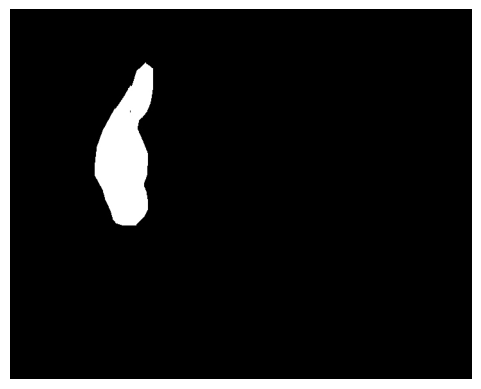

In [23]:
import cv2
import matplotlib.pyplot as plt

# Read the first image from mask images
mask_img1 = cv2.imread(os.path.join(chemin_masks, fichiers_masks[0]), cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded successfully
if mask_img1 is None:
    print("Error: Unable to load the image.")
else:
    # Normalize the image
    normalized_img = mask_img1 / 255.0

    # Display image
    plt.imshow(normalized_img, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

In [24]:
# Check shape of mask
mask_img1.shape

(576, 720)

In [25]:
#Find out the min and max values of pixels in the RGB image
print('RGB Image:')
print('Image minimum value: ',RGB_img1.min())
print('Image maximum value: ',RGB_img1.max())

#Find out the min and max values of pixels in the mask image
print('Mask Image:')
print('Image minimum value: ',mask_img1.min())
print('Image maximum value: ',mask_img1.max())

RGB Image:
Image minimum value:  0
Image maximum value:  255
Mask Image:
Image minimum value:  0
Image maximum value:  255


In [26]:
from PIL import Image

# Define the target size for images and masks
target_size = (256, 256)

# Empty list to store Booleans of whether or not the size of images and masks are equal
bool_size = []

# Iterate over the image and mask files simultaneously
for image_file, mask_file in zip(fichiers_images, fichiers_masks):
    # Get the paths to the image and mask files
    image_path = os.path.join(chemin_images, image_file)
    mask_path = os.path.join(chemin_masks, mask_file)

    # Open and resize the image and mask
    with Image.open(image_path) as image, Image.open(mask_path) as mask:
        # Resize the image and mask
        image_resized = image.resize(target_size)
        mask_resized = mask.resize(target_size)

        # Convert to numpy arrays for normalization
        image_array = np.array(image_resized) / 255.0
        mask_array = np.array(mask_resized) / 255.0

        # Check if the dimensions are equal
        if image_resized.size == mask_resized.size:
            bool_size.append(True)
        else:
            bool_size.append(False)

# Check if all elements are True
print(f"{all(bool_size)}, both images and masks have been resized and normalized.")

True, both images and masks have been resized and normalized.


In [27]:
heights = [cv2.imread(os.path.join(chemin_images,fichiers_images[idx])).shape[0] for idx in range(len(fichiers_images))]
widths = [cv2.imread(os.path.join(chemin_images,fichiers_images[idx])).shape[1] for idx in range(len(fichiers_images))]
print(heights)
print(widths)

[576, 576, 576, 576, 576, 576, 576, 576, 576, 576, 576, 1072, 576, 576, 529, 1070, 529, 528, 528, 547, 530, 1019, 531, 530, 529, 530, 546, 547, 531, 546, 529, 531, 531, 546, 530, 547, 528, 547, 546, 529, 529, 530, 528, 530, 530, 546, 529, 547, 530, 528, 547, 510, 528, 511, 531, 528, 526, 529, 529, 511, 531, 528, 546, 528, 528, 529, 547, 547, 528, 546, 528, 530, 531, 530, 530, 530, 546, 546, 530, 529, 529, 505, 547, 530, 531, 529, 546, 531, 531, 547, 529, 530, 528, 531, 1070, 528, 546, 528, 529, 547, 513, 529, 529, 531, 529, 547, 547, 531, 530, 529, 529, 547, 530, 530, 528, 528, 547, 547, 547, 530, 531, 531, 521, 502, 528, 528, 531, 529, 529, 529, 528, 531, 528, 531, 531, 530, 529, 530, 531, 531, 1070, 530, 530, 530, 528, 531, 530, 529, 528, 487, 529, 530, 528, 528, 531, 546, 531, 522, 546, 530, 528, 530, 530, 519, 531, 546, 531, 547, 531, 528, 530, 1070, 546, 529, 518, 531, 547, 547, 547, 531, 1070, 530, 530, 530, 547, 528, 531, 511, 528, 529, 1070, 530, 528, 529, 530, 530, 531, 529, 5

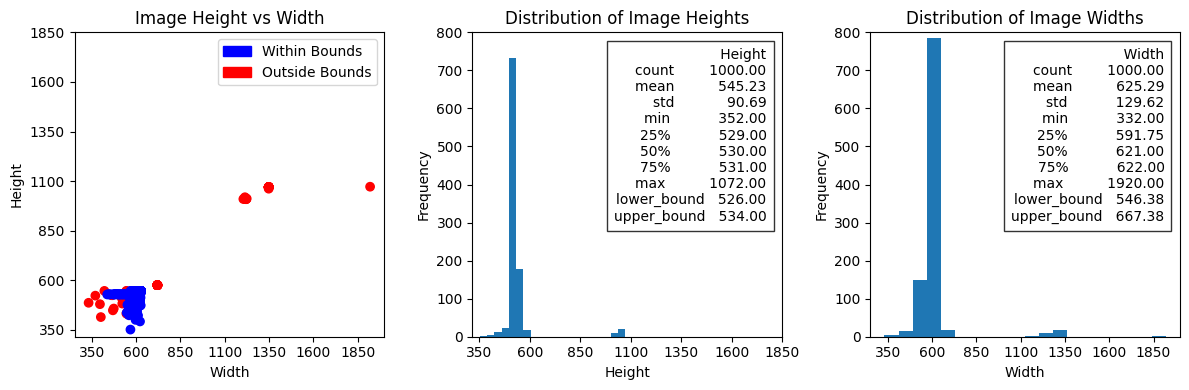

In [28]:
import matplotlib.patches as mpatches

# Create a DataFrame with heights and widths
df = pd.DataFrame({'Height': heights, 'Width': widths})

# Generate the summary statistics
summary = round(df.describe(), 2)

# Calculate the lower bound and upper bound
q1 = summary.loc['25%']
q3 = summary.loc['75%']
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Add the lower bound and upper bound to the summary
summary.loc['lower_bound'] = round(lower_bound,2)
summary.loc['upper_bound'] = round(upper_bound,2)

# Create a figure with two subplots and a scatter plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the scatter plot of heights and widths
colors = np.where((heights >= lower_bound['Height']) & (heights <= upper_bound['Height']) |
                  (widths >= lower_bound['Width']) & (widths <= upper_bound['Width']), 'blue', 'red')

scatter = axs[0].scatter(widths, heights, c=colors)
axs[0].set_xlabel('Width')
axs[0].set_ylabel('Height')
axs[0].set_title('Image Height vs Width')
axs[0].set_xticks(np.arange(350, 1920, 250))
axs[0].set_yticks(np.arange(350, 1920, 250))

# Create legend labels
legend_labels = [mpatches.Patch(color='blue', label='Within Bounds'),
                 mpatches.Patch(color='red', label='Outside Bounds')]

# Add legend
axs[0].legend(handles=legend_labels)

# Plot the histogram of heights
axs[1].hist(heights, bins=20)
axs[1].set_xlabel('Height')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Image Heights')
axs[1].set_xticks(np.arange(350, 1920, 250))
axs[1].text(0.95, 0.95, str(summary[['Height']]), transform=axs[1].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Plot the histogram of widths
axs[2].hist(widths, bins=20)
axs[2].set_xlabel('Width')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Image Widths')
axs[2].text(0.95, 0.95,
            str(summary[['Width']]),
            transform=axs[2].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
axs[2].set_xticks(np.arange(350, 1920, 250))

# Set the same vertical scale for both histograms
axs[1].set_ylim([0, 800])
axs[2].set_ylim([0, 800])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

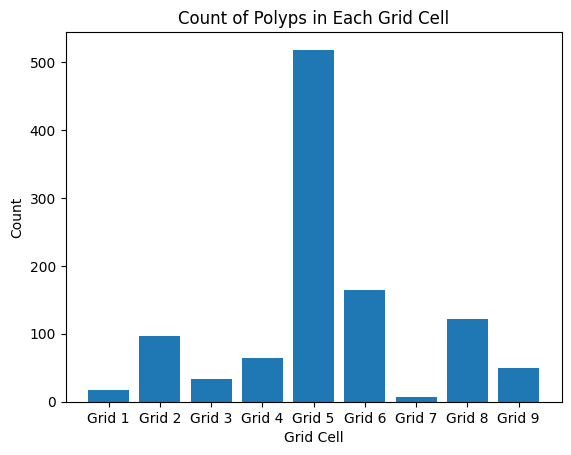

In [29]:
# Initialize a 3x3 grid to store the grid counts
grid_counts = [[0] * 3 for _ in range(3)]

# Iterate over the bounding box data
for image_data in kavsir_bboxes.values():
    height = image_data['height']
    width = image_data['width']
    for bbox in image_data['bbox']:
        # Extract the coordinates
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']

        # Calculate the center coordinates
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2

        # Determine the grid cell based on the center coordinates
        grid_row = int(y_center / (height / 3))
        grid_col = int(x_center / (width / 3))

        # Increment the count for the corresponding grid cell
        grid_counts[grid_row][grid_col] += 1

# Flatten the grid counts into a 1D list
counts = [count for row in grid_counts for count in row]

# Define the labels for the grid cells
labels = ['Grid {}'.format(i+1) for i in range(9)]

# Create a bar chart
x_pos = np.arange(len(labels))
plt.bar(x_pos, counts, align='center')

# Set the axis labels and title
plt.xlabel('Grid Cell')
plt.ylabel('Count')
plt.title('Count of Polyps in Each Grid Cell')

# Set the x-axis tick labels
plt.xticks(x_pos, labels)

# Display the plot
plt.show()

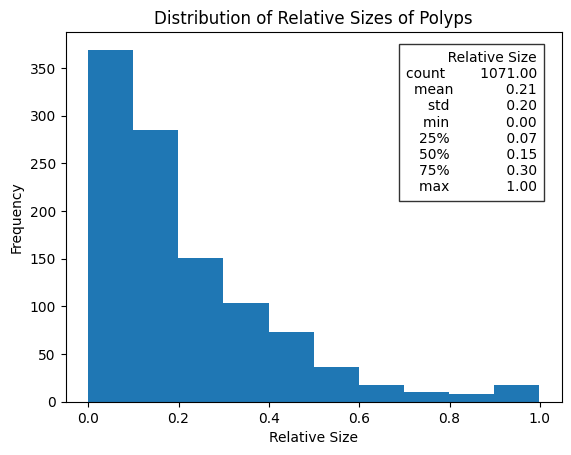

In [30]:
# Empty list to store all the relative sizes
relative_sizes = []

# Iterate over the bounding box data
for image_data in kavsir_bboxes.values():
    height = image_data['height']
    width = image_data['width']
    for bbox in image_data['bbox']:
        # Extract the coordinates
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']

        # Calculate the width and height of the bounding box
        bbox_width = xmax - xmin
        bbox_height = ymax - ymin

        # Calculate the area of the bounding box
        bbox_area = bbox_width * bbox_height

        # Calculate the area of the image
        image_area = height * width

        # Calculate the relative size of the bounding box
        relative_size = bbox_area / image_area

        # Append the relative size to the list
        relative_sizes.append(relative_size)

# Calculate the summary statistics
summary = pd.DataFrame({'Relative Size': relative_sizes}).describe().round(2)

# Plot the histogram of relative sizes
n, bins, patches = plt.hist(relative_sizes)
plt.xlabel('Relative Size')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Sizes of Polyps')

# Add the summary statistics to the plot as text annotations
summary_text = str(summary[['Relative Size']])
plt.text(0.95, 0.95,
         summary_text,
         transform=plt.gca().transAxes,
         ha='right', va='top',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Display the plot
plt.show()

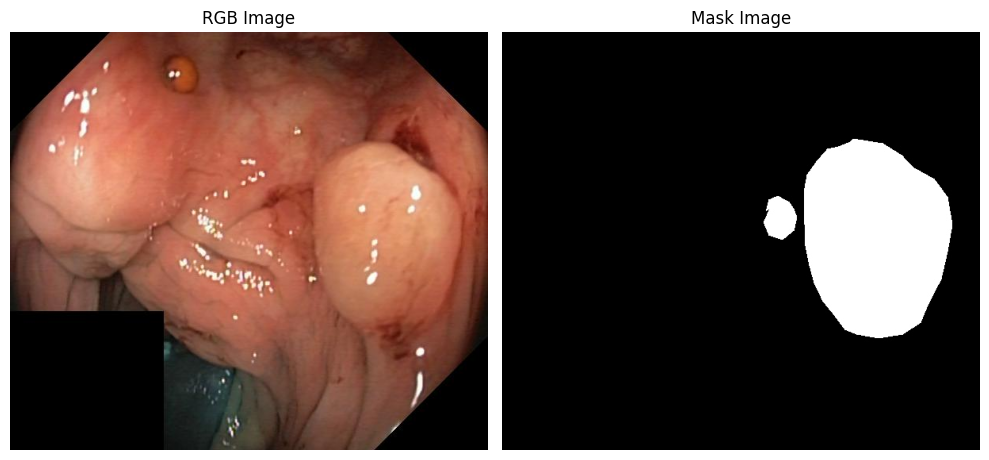

In [31]:
# Load RGB image and mask
image_path = os.path.join(chemin_images, fichiers_images[-7])
mask_path = os.path.join(chemin_masks, fichiers_masks[-7])
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('RGB Image')
axs[0].axis('off')

# Plot the mask image
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask Image')
axs[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

100%|██████████| 1000/1000 [00:33<00:00, 30.21it/s]


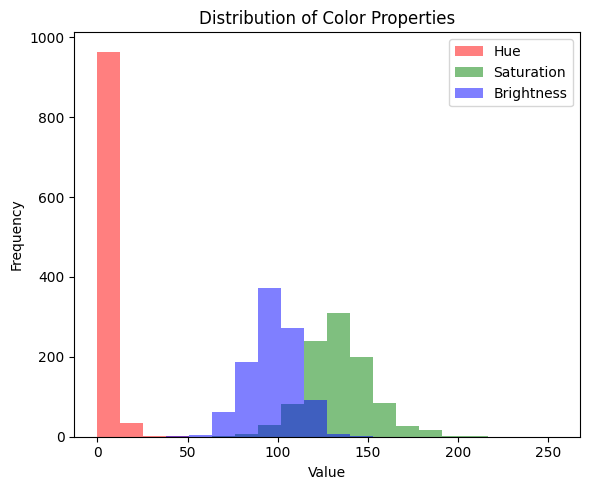

Hue  Saturation  Brightness
count     1000.00     1000.00     1000.00
mean         9.03      134.14       97.48
std          2.40       18.28       13.46
min          4.28       75.41       48.13
25%          7.82      122.69       88.91
50%          8.65      133.69       97.60
75%          9.71      144.66      106.68
max         48.53      206.39      151.25
skewness     6.69        0.29       -0.23

In [32]:
# Calculate the average brightness, hue, and saturation of the images
brightness_values = []
hue_values = []
saturation_values = []

# Create a progress bar for the loop
for image_file in tqdm(fichiers_images):
    # Load the image
    image_path = os.path.join(chemin_images, image_file)
    image = cv2.imread(image_path)

    # Convert the image to different color spaces
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the average pixel intensities
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    brightness_values.append(brightness)

    # Calculate the average hue value
    hue = np.mean(hsv_image[:, :, 0])
    hue_values.append(hue)

    # Calculate the average saturation value
    saturation = np.mean(hsv_image[:, :, 1])
    saturation_values.append(saturation)

# Set the same range for the x-axis
x_axis_range = (0, 255)  # Adjust this range as per your requirement

# Display the histograms of hue, saturation, and brightness values
plt.figure(figsize=(6, 5))
n, bins, patches = plt.hist(hue_values, bins=20, range=x_axis_range, color='r', alpha=0.5, label='Hue')
plt.hist(saturation_values, bins=20, range=x_axis_range, color='g', alpha=0.5, label='Saturation')
plt.hist(brightness_values, bins=20, range=x_axis_range, color='b', alpha=0.5, label='Brightness')

# Set the labels, title, and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Color Properties')
plt.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Create a DataFrame with hue, saturation, and brightness values
df = pd.DataFrame({'Hue': hue_values, 'Saturation': saturation_values, 'Brightness': brightness_values})

# Generate the summary statistics including skewness
summary = round(df.describe(), 2)
summary.loc['skewness'] = round(df.skew(), 2)

# Display the statistics
display(summary)

diviser le dataset en un ensemble de train , un ensemble de valid et un ensemble de test

In [33]:
# Set the path to the dataset
full_path = "/content/drive/MyDrive/kvasir-seg (2)"

# Get the paths to the images and masks in the dataset
images = glob(os.path.join(full_path, "images/", "*"))
masks = glob(os.path.join(full_path, "masks/", "*"))

# Sort the image and mask paths
images.sort()
masks.sort()

# Define the path for the new organized dataset
new_full_path = "new_data/"
if not os.path.exists(new_full_path):
    os.mkdir(new_full_path)

# Define the paths for the training, validation, and testing sets
train_path = os.path.join(new_full_path, "train")
valid_path = os.path.join(new_full_path, "valid")
test_path = os.path.join(new_full_path, "test")

# Create the directories for the training, validation, and testing sets
if not os.path.exists(train_path):
    for path in [train_path, valid_path, test_path]:
        os.mkdir(path)
        os.mkdir(os.path.join(path, "images"))
        os.mkdir(os.path.join(path, "masks"))

# Calculate the sizes of the training, validation, and testing sets
len_ids = len(images)
train_size = int((80/100) * len_ids)
valid_size = int((10/100) * len_ids)  # 10% of the images used for validation
test_size = int((10/100) * len_ids)  # 10% of the images used for testing

# Split the images and masks into training and testing sets
train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
train_masks, test_masks = train_test_split(masks, test_size=test_size, random_state=42)

# Further split the training set into training and validation sets
train_images, valid_images = train_test_split(train_images, test_size=test_size, random_state=42)
train_masks, valid_masks = train_test_split(train_masks, test_size=test_size, random_state=42)

# Print the sizes of the dataset subsets
print("Total Size: ", len_ids)
print("Training Size: ", train_size)
print("Validation Size: ", valid_size)
print("Testing Size: ", test_size)

Total Size:  1000
Training Size:  800
Validation Size:  100
Testing Size:  100


In [34]:
# Iterate over the test images and masks
for idx, p in tqdm(enumerate(test_images), total=len(test_images)):
    # Extract the name of the image from the path
    name = p.split('\\')[-1].split('.')[0].split('_')[-1]

    # Get the paths for the image and mask
    image_path = test_images[idx]
    mask_path = test_masks[idx]

    # Check if the image and mask paths exist
    if os.path.exists(image_path) and os.path.exists(mask_path):
        # Read and save the test image
        image = cv2.imread(image_path)
        image_path = os.path.join(test_path, "images/", f"{str(name)}.jpg")
        cv2.imwrite(image_path, image)

        # Read, convert to grayscale, and save the test mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_path = os.path.join(test_path, "masks/", f"{str(name)}.jpg")
        cv2.imwrite(mask_path, mask)

100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Test Image Size:  100
Test Mask Size:  100


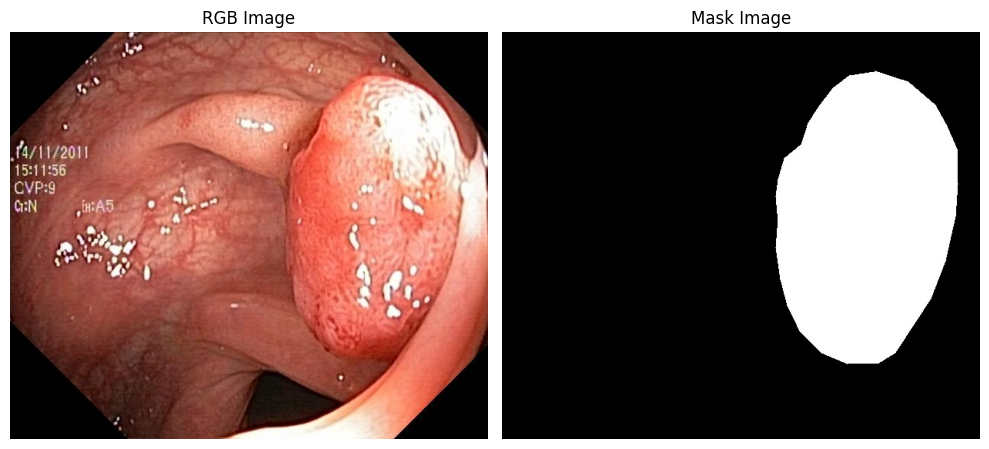

In [35]:
# Set the path to the images and masks in the test directory
test_images_path = os.path.join(test_path, "images")
test_images = os.listdir(test_images_path)
test_masks_path = os.path.join(test_path, "masks")
test_masks = os.listdir(test_masks_path)

# Verify test mask and image sizes
print("Test Image Size: ", len(test_images))
print("Test Mask Size: ", len(test_masks))

# Read a test image
BGR_img1 = cv2.imread(os.path.join(test_images_path, test_images[2]))

# Convert BGR image to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Read a test mask
mask_img1 = cv2.imread(os.path.join(test_masks_path, test_masks[2]))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(RGB_img1)
axs[0].set_title('RGB Image')

# Plot the mask image
axs[1].imshow(mask_img1)
axs[1].set_title('Mask Image')

# Remove the ticks and labels from both subplots
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [36]:
# Iterate over the validation images and masks
for idx, p in tqdm(enumerate(valid_images), total=len(valid_images)):
    # Extract the name of the image from the path
    name = p.split('\\')[-1].split('.')[0].split('_')[-1]

    # Get the paths for the image and mask
    image_path = valid_images[idx]
    mask_path = valid_masks[idx]

    # Check if the image and mask paths exist
    if os.path.exists(image_path) and os.path.exists(mask_path):
        # Read and save the validation image
        image = cv2.imread(image_path)
        image_path = os.path.join(valid_path, "images/", f"{str(name)}.jpg")
        cv2.imwrite(image_path, image)

        # Read, convert to grayscale, and save the validation mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_path = os.path.join(valid_path, "masks/", f"{str(name)}.jpg")
        cv2.imwrite(mask_path, mask)

100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Validation Image Size:  100
Validation Mask Size:  100


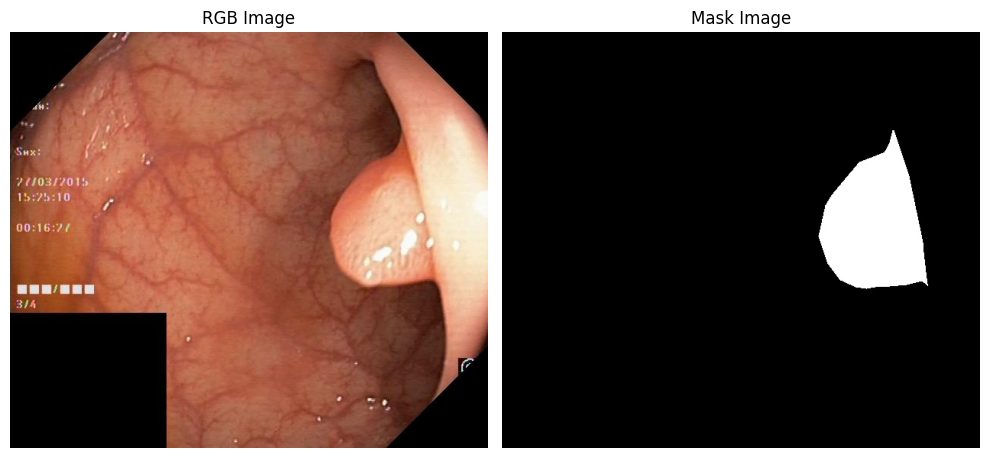

In [37]:
# Set the path to the images and masks in the validation directory
valid_images_path = os.path.join(valid_path, "images")
valid_images = os.listdir(valid_images_path)
valid_masks_path = os.path.join(valid_path, "masks")
valid_masks = os.listdir(valid_masks_path)

# Verify validation mask and image sizes
print("Validation Image Size: ", len(valid_images))
print("Validation Mask Size: ", len(valid_masks))

# Read a validation image
BGR_img1 = cv2.imread(os.path.join(valid_images_path, valid_images[2]))

# Convert BGR image to RGB and normalize pixel values to [0, 1]
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB) / 255.0

# Read a validation mask
mask_img1 = cv2.imread(os.path.join(valid_masks_path, valid_masks[2]), cv2.IMREAD_GRAYSCALE)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(RGB_img1)
axs[0].set_title('RGB Image')

# Plot the mask image
axs[1].imshow(mask_img1, cmap='gray')
axs[1].set_title('Mask Image')

# Remove the ticks and labels from both subplots
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [38]:
# Définir manuellement les noms de classe et leurs valeurs RGB
class_names = ['background', 'polyp']
class_rgb_values = [(0, 0, 0), (255, 255, 255)]


# Afficher les noms de classe et leurs valeurs RGB
print('Toutes les classes du jeu de données et leurs valeurs RGB correspondantes dans les étiquettes:')
print('Noms de classe: ', class_names)
print('Valeurs RGB des classes: ', class_rgb_values)

Toutes les classes du jeu de données et leurs valeurs RGB correspondantes dans les étiquettes:
Noms de classe:  ['background', 'polyp']
Valeurs RGB des classes:  [(0, 0, 0), (255, 255, 255)]


In [39]:
# Iterate over the train images and masks
for idx, p in tqdm(enumerate(train_images), total=len(train_images)):
    # Extract the name of the image from the path
    name = p.split('\\')[-1].split('.')[0].split('_')[-1]

    # Get the paths for the image and mask
    image_path = train_images[idx]
    mask_path = train_masks[idx]

    # Check if the image and mask paths exist
    if os.path.exists(image_path) and os.path.exists(mask_path):
        # Read and save the train image
        image = cv2.imread(image_path)
        image_path = os.path.join(train_path, "images/", f"{str(name)}.jpg")
        cv2.imwrite(image_path, image)

        # Read, convert to grayscale, and save the train mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_path = os.path.join(train_path, "masks/", f"{str(name)}.jpg")
        cv2.imwrite(mask_path, mask)

100%|██████████| 800/800 [00:30<00:00, 26.21it/s]


Train Image Size:  800
Train Mask Size:  800


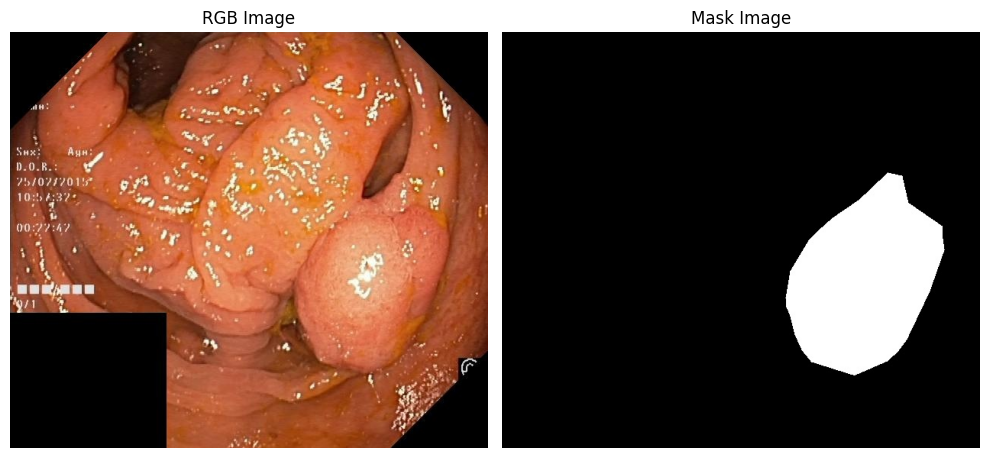

In [40]:
# Set the path to the images and masks in the train directory
train_images_path = os.path.join(train_path, "images")
train_images = os.listdir(train_images_path)
train_masks_path = os.path.join(train_path, "masks")
train_masks = os.listdir(train_masks_path)

# Verify train mask and image sizes
print("Train Image Size: ", len(train_images))
print("Train Mask Size: ", len(train_masks))

# Read a train image
BGR_img1 = cv2.imread(os.path.join(train_images_path, train_images[2]))

# Convert BGR image to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Read a train mask
mask_img1 = cv2.imread(os.path.join(train_masks_path, train_masks[2]))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(RGB_img1)
axs[0].set_title('RGB Image')

# Plot the mask image
axs[1].imshow(mask_img1)
axs[1].set_title('Mask Image')

# Remove the ticks and labels from both subplots
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [41]:
import os
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Grayscale mask

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

def generate_data_batches(data_dir, batch_size, target_size, seed=None, train_augmentation=False):
    """
    Generate data batches for image segmentation tasks.

    Args:
        data_dir (str): The directory containing the dataset with subdirectories for train, validation, and test sets.
        batch_size (int): The batch size to use for the data loaders.
        target_size (tuple): The target size to resize the images and masks, specified as (height, width).
        seed (int or None, optional): Random seed for reproducibility. Defaults to None.
        train_augmentation (bool, optional): Flag to enable data augmentation for the training set. Defaults to False.

    Returns:
        tuple: A tuple containing the following data loaders:
            - train_loader (DataLoader): Data loader for training set images.
            - valid_loader (DataLoader): Data loader for validation set images.
            - test_loader (DataLoader): Data loader for test set images.
    """

    if seed is not None:
        torch.manual_seed(seed)

    common_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    mask_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    if train_augmentation:
        train_transforms = transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        train_transforms = common_transforms

    train_dataset = SegmentationDataset(
        os.path.join(data_dir, 'train/images'),
        os.path.join(data_dir, 'train/masks'),
        transform=train_transforms,
        mask_transform=mask_transforms
    )

    valid_dataset = SegmentationDataset(
        os.path.join(data_dir, 'valid/images'),
        os.path.join(data_dir, 'valid/masks'),
        transform=common_transforms,
        mask_transform=mask_transforms
    )

    test_dataset = SegmentationDataset(
        os.path.join(data_dir, 'test/images'),
        os.path.join(data_dir, 'test/masks'),
        transform=common_transforms,
        mask_transform=mask_transforms
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, valid_loader, test_loader

# Set parameters for `generate_data_batches` function
data_dir = './new_data/'
batch_size = 16
seed = 123
target_size = (256, 256)

# Generate the data batches using the specified parameters
train_loader, valid_loader, test_loader = generate_data_batches(
    data_dir,
    batch_size,
    target_size=target_size,
    seed=seed,
    train_augmentation=True
)


In [42]:
# Get the number of samples in the train dataset
train_samples = len(train_loader.dataset)

# Get the batch size
batch_size = train_loader.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Train Images")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Images
Number of samples: 800
Batch size: 16
Number of batches (train steps): 50


In [43]:
# Importing necessary libraries
import os
import torch
from torch.utils.data import DataLoader

# Assuming train_masks_gen is a DataLoader object in PyTorch

# Get the number of samples in the train masks dataset
train_mask_samples = len(train_loader.dataset)

# Get the batch size

# Calculate the number of steps per epoch (number of batches)
train_mask_steps = train_mask_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Train Masks")
print("Number of samples:", train_mask_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_mask_steps))

Train Masks
Number of samples: 800
Batch size: 16
Number of batches (train steps): 50


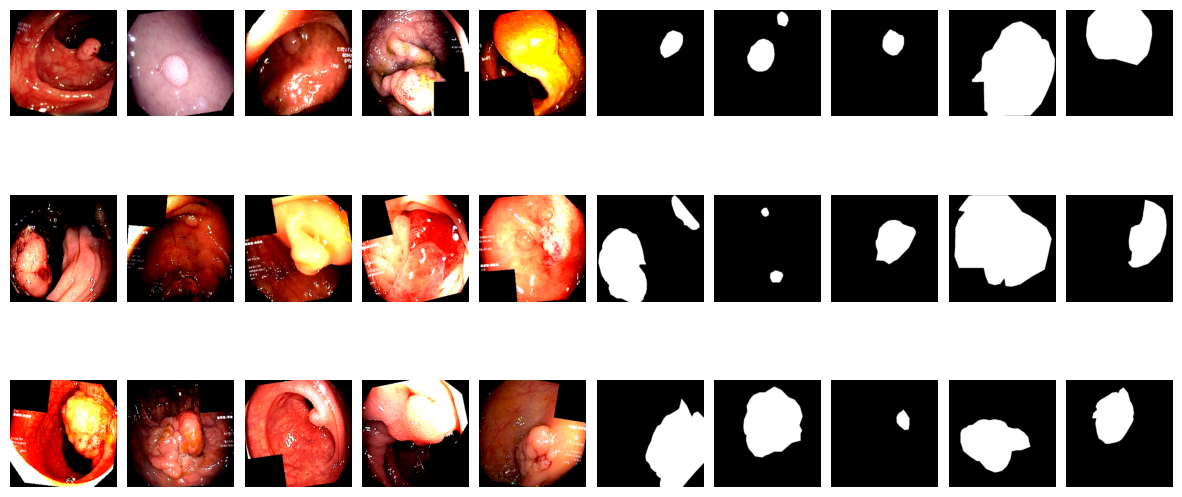

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Define the normalization parameters
mean = 0.5
std = 0.5

# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(15, 7))

# Iterate over the batches and plot the images and masks
for i, (batch_images, batch_masks) in enumerate(train_loader):
    if i == num_batches:
        break

    batch_images = batch_images[:images_per_batch]
    batch_masks = batch_masks[:images_per_batch]

    for j in range(images_per_batch):
        # Convert tensors to numpy arrays and reshape if necessary
        image_np = batch_images[j].permute(1, 2, 0).numpy()
        mask_np = batch_masks[j].squeeze().numpy()

        # Normalize the image
        image_np = (image_np * std) + mean

        # Plot the image
        axes[i, j].imshow(image_np)
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(mask_np, cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

**Image preprocessing Data generator and Modeling**

In [45]:
# PyTorch and torchvision for machine learning operations
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

import torchvision.transforms as transforms

# Matplotlib and Seaborn for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NumPy for numerical operations
import numpy as np

# Random for generating random numbers
import random

# Scikit-learn metrics for evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
chemin_du_fichier =   '/content/drive/MyDrive/kvasir-seg (2)/'

Mounted at /content/drive


Generate data batches

In [47]:
def generate_data_batches(data_dir, batch_size, target_size, seed=None, train_augmentation=False):
    """
    Generate data batches for image segmentation tasks.

    Args:
        data_dir (str): The directory containing the dataset with subdirectories for train, validation, and test sets.
        batch_size (int): The batch size to use for the data loaders.
        target_size (tuple): The target size to resize the images and masks, specified as (height, width).
        seed (int or None, optional): Random seed for reproducibility. Defaults to None.
        train_augmentation (bool, optional): Flag to enable data augmentation for the training set. Defaults to False.

    Returns:
        tuple: A tuple containing the following data loaders:
            - train_loader (DataLoader): Data loader for the training set.
            - valid_loader (DataLoader): Data loader for the validation set.
            - test_loader (DataLoader): Data loader for the test set.
    """

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    rescale_factor = 1.0 / 255.0

    if train_augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomResizedCrop(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    val_test_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = SegmentationDataset(
        image_dir=os.path.join(data_dir, 'train/images'),
        mask_dir=os.path.join(data_dir, 'train/masks'),
        transform=train_transform
    )

    valid_dataset = SegmentationDataset(
        image_dir=os.path.join(data_dir, 'valid/images'),
        mask_dir=os.path.join(data_dir, 'valid/masks'),
        transform=val_test_transform
    )

    test_dataset = SegmentationDataset(
        image_dir=os.path.join(data_dir, 'test/images'),
        mask_dir=os.path.join(data_dir, 'test/masks'),
        transform=val_test_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, valid_loader, test_loader

In [48]:
# Set parameters for `generate_data_batches` functon
data_dir = './new_data/'
batch_size = 16
seed = 123
target_size = (256, 256)

# Generate the data batches using the specified parameters
train_loader, valid_loader, test_loader = generate_data_batches(
    data_dir,
    batch_size,
    target_size,
    seed,
    train_augmentation=True
)

# Pack train loader as `(x, y)` and validation loader as `(x_val, y_val)`
# In PyTorch, train_loader and valid_loader already yield `(x, y)` tuples
train_generator = train_loader
val_generator = valid_loader

In [49]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

# Définir une classe de dataset personnalisé pour la segmentation
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = os.listdir(image_dir)
        self.mask_filenames = os.listdir(mask_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

def generate_data_batches(data_dir, batch_size, target_size, seed=None, train_augmentation=False):
    """
    Generate data batches for image segmentation tasks.

    Args:
        data_dir (str): The directory containing the dataset with subdirectories for train, validation, and test sets.
        batch_size (int): The batch size to use for the data loaders.
        target_size (tuple): The target size to resize the images and masks, specified as (height, width).
        seed (int or None, optional): Random seed for reproducibility. Defaults to None.
        train_augmentation (bool, optional): Flag to enable data augmentation for the training set. Defaults to False.

    Returns:
        tuple: A tuple containing the following data loaders:
            - train_loader (DataLoader): Data loader for the training set.
            - valid_loader (DataLoader): Data loader for the validation set.
            - test_loader (DataLoader): Data loader for the test set.
    """

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    rescale_factor = 1.0 / 255.0

    if train_augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomResizedCrop(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    val_test_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = SegmentationDataset(
        image_dir=os.path.join(data_dir, 'train/images'),
        mask_dir=os.path.join(data_dir, 'train/masks'),
        transform=train_transform
    )

    valid_dataset = SegmentationDataset(
        image_dir=os.path.join(data_dir, 'valid/images'),
        mask_dir=os.path.join(data_dir, 'valid/masks'),
        transform=val_test_transform
    )

    test_dataset = SegmentationDataset(
        image_dir=os.path.join(data_dir, 'test/images'),
        mask_dir=os.path.join(data_dir, 'test/masks'),
        transform=val_test_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


    print(f"Found {len(train_dataset)} images belonging to train set.")
    print(f"Found {len(train_dataset)} masks belonging to train set.")
    print(f"Found {len(valid_dataset)} images belonging to validation set.")
    print(f"Found {len(valid_dataset)} masks belonging to validation set.")
    print(f"Found {len(test_dataset)} images belonging to test set.")
    print(f"Found {len(test_dataset)} masks belonging to test set.")

    return train_loader, valid_loader, test_loader

# Définir les paramètres pour la fonction `generate_data_batches`
data_dir = './new_data/'
batch_size = 16
seed = 123
target_size = (256, 256)

# Générer les DataLoaders en utilisant les paramètres spécifiés
train_loader, valid_loader, test_loader = generate_data_batches(
    data_dir,
    batch_size,
    target_size=target_size,
    seed=seed,
    train_augmentation=True
)




Found 800 images belonging to train set.
Found 800 masks belonging to train set.
Found 100 images belonging to validation set.
Found 100 masks belonging to validation set.
Found 100 images belonging to test set.
Found 100 masks belonging to test set.


Train batches

In [50]:
# Obtenir le nombre de données dans le DataLoader d'entraînement
train_samples = len(train_loader.dataset)

# Obtenir la taille du batch
batch_size = train_loader.batch_size

# Calculer le nombre d'étapes par époque (nombre de lots)
train_steps = len(train_loader)

# Afficher le nombre de données, la taille du batch et le nombre d'étapes
print("Train Images")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", train_steps)


Train Images
Number of samples: 800
Batch size: 16
Number of batches (train steps): 50


In [51]:
# Obtenir le nombre de données dans le DataLoader d'entraînement
train_samples = len(train_loader.dataset)

# Obtenir la taille du batch à partir du DataLoader
batch_size = train_loader.batch_size

# Calculer le nombre d'étapes par époque (nombre de lots)
train_steps = len(train_loader)

# Afficher le nombre de données, la taille du batch et le nombre d'étapes
print("Train Masks")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", train_steps)


Train Masks
Number of samples: 800
Batch size: 16
Number of batches (train steps): 50


Let's visualize some examples of our train batches. We will look at the first 5 images of our first 3 batches.

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Assurez-vous que le DataLoader est défini correctement avec les transformations nécessaires
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Définir un DataLoader pour l'ensemble d'entraînement
train_dataset = SegmentationDataset(
    image_dir=os.path.join(data_dir, 'train/images'),
    mask_dir=os.path.join(data_dir, 'train/masks'),
    transform=train_transform,
    mask_transform=mask_transform
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Obtenez un itérateur du DataLoader
train_iterator = iter(train_loader)

# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(15, 7))

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    # Get the next batch of images and masks
    batch_images, batch_masks = next(train_iterator)
    batch_images = batch_images[:images_per_batch]
    batch_masks = batch_masks[:images_per_batch]

    for j in range(images_per_batch):
        # Convert tensor to numpy array and transpose for matplotlib
        image = batch_images[j].permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())  # Normalize for display

        # Plot the image
        axes[i, j].imshow(image)
        axes[i, j].axis('off')

        # Plot the mask (remove the channel dimension)
        mask = batch_masks[j].squeeze().numpy()
        axes[i, j + images_per_batch].imshow(mask, cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()





TypeError: SegmentationDataset.__init__() got an unexpected keyword argument 'mask_transform'

In [53]:
print("Minimum train image pixel value:", batch_images[0].min())
print("Maximum train image pixel value:", batch_images[0].max())
print("Minimum train mask pixel value:", batch_masks[0].min())
print("Maximum train mask pixel value:", batch_masks[0].max())

Minimum train image pixel value: tensor(-2.1179)
Maximum train image pixel value: tensor(2.6400)
Minimum train mask pixel value: tensor(0.)
Maximum train mask pixel value: tensor(1.)


Validation batches

In [54]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Chargement des datasets
valid_dataset = SegmentationDataset(
    image_dir=os.path.join(data_dir, 'valid/images'),
    mask_dir=os.path.join(data_dir, 'valid/masks'),
    transform=transform
)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

# Obtenir le nombre de samples et autres informations
validation_samples = len(valid_dataset)
batch_size = valid_loader.batch_size
validation_steps = validation_samples / batch_size

# Afficher les informations
print("Validation Images")
print("Number of samples:", validation_samples)
print("Batch size:", batch_size)
print("Number of batches (validation steps):", round(validation_steps))


Validation Images
Number of samples: 100
Batch size: 16
Number of batches (validation steps): 6


In [55]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Chargement des datasets
valid_dataset = SegmentationDataset(
    image_dir=os.path.join(data_dir, 'valid/images'),
    mask_dir=os.path.join(data_dir, 'valid/masks'),
    transform=transform
)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

# Obtenir le nombre de samples et autres informations
validation_mask_samples = len(valid_dataset)
batch_size = valid_loader.batch_size
validation_steps = validation_mask_samples / batch_size

# Afficher les informations
print("Validation Masks")
print("Number of validation samples:", validation_mask_samples)
print("Batch size:", batch_size)
print("Number of validation batches (validation steps):", round(validation_steps))


Validation Masks
Number of validation samples: 100
Batch size: 16
Number of validation batches (validation steps): 6


Let's visualize some examples of our validation batches. We will look at the first 5 images of our first 3 batches.

In [56]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Définir les transformations pour les images et les masques
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Définir les datasets et dataloaders
train_dataset = SegmentationDataset(
    image_dir='./new_data/train/images',
    mask_dir='./new_data/train/masks',
    transform=image_transform,
    mask_transform=mask_transform
)

valid_dataset = SegmentationDataset(
    image_dir='./new_data/valid/images',
    mask_dir='./new_data/valid/masks',
    transform=image_transform,
    mask_transform=mask_transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)



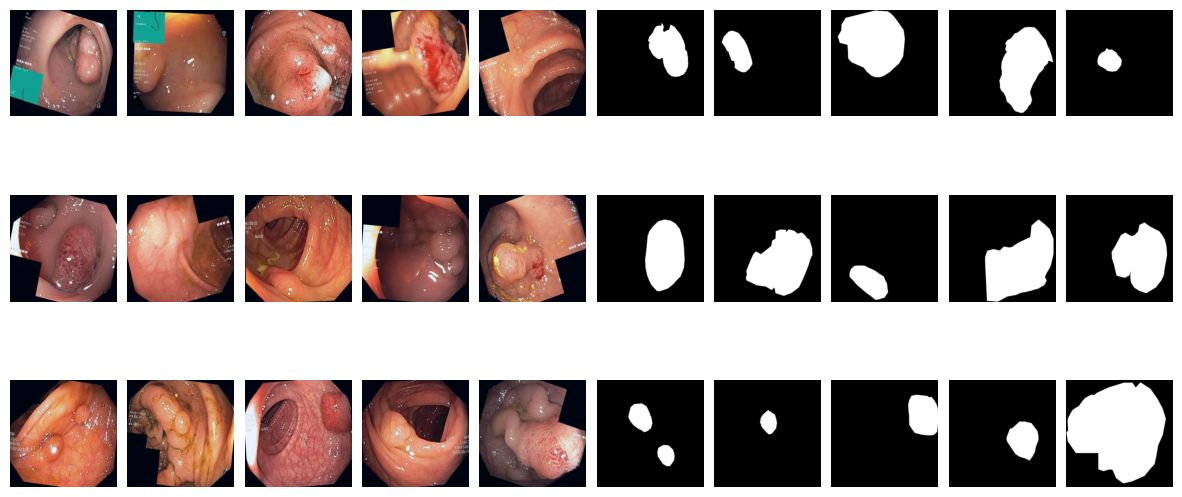

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(15, 7))

# Create an iterator from the validation DataLoader
val_iterator = iter(valid_loader)

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    # Get the next batch of images and masks
    batch_images, batch_masks = next(val_iterator)
    batch_images = batch_images[:images_per_batch]
    batch_masks = batch_masks[:images_per_batch]

    for j in range(images_per_batch):
        # Convert tensor to numpy array and transpose for matplotlib
        img = batch_images[j].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        mask = batch_masks[j].squeeze().numpy()  # Remove channel dimension

        # Plot the image
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(mask, cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()


In [58]:
print("Minimum validation image pixel value:", batch_images[0].min())
print("Maximum validation image pixel value:", batch_images[0].max())
print("Minimum validation mask pixel value:", batch_masks[0].min())
print("Maximum validation mask pixel value:", batch_masks[0].max())

Minimum validation image pixel value: tensor(-2.1179)
Maximum validation image pixel value: tensor(2.6400)
Minimum validation mask pixel value: tensor(0.)
Maximum validation mask pixel value: tensor(1.)


Test batch

In [59]:
# Obtenir la taille des lots du test_loader
test_batch_size = test_loader.batch_size

# Imprimer la taille des lots
print("Test batch size:", test_batch_size)


Test batch size: 16


Let's visualize first 15 images of our test batch.

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-49-68b0d6189c8c>", line 28, in __getitem__
    mask = self.transform(mask)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/transforms.py", line 277, in forward
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py", line 350, in normalize
    return F_t.normalize(tensor, mean=mean, std=std, inplace=inplace)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_tensor.py", line 926, in normalize
    return tensor.sub_(mean).div_(std)
RuntimeError: output with shape [1, 256, 256] doesn't match the broadcast shape [3, 256, 256]


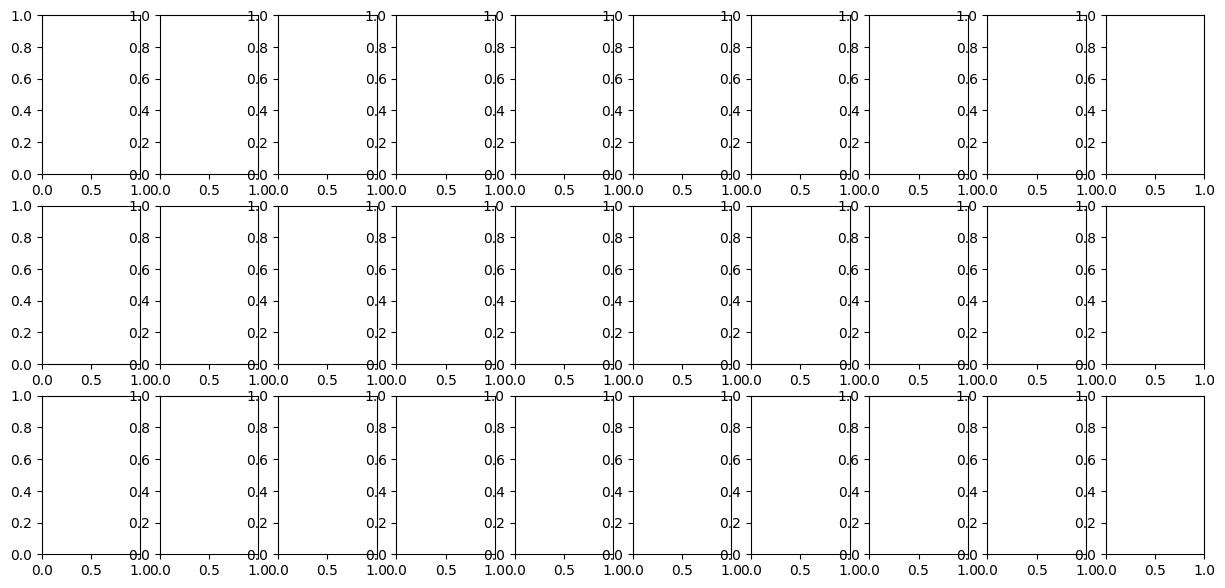

In [60]:
# Set the number of rows and columns for the grid
num_rows = 3
num_cols = 5
total_images = num_rows * num_cols  # Total of 15 images to display

# Plot the images and masks in a grid
fig, axes = plt.subplots(num_rows, 2 * num_cols, figsize=(15, 7))

# Get the test batch
test_batch_images, test_batch_masks = next(iter(test_loader))

# Iterate over the images in the test batch and plot them in the grid
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        # Normalize and convert images to numpy arrays for plotting
        img = (test_batch_images[index].numpy().transpose(1, 2, 0) * 0.5) + 0.5  # Denormalize and CHW to HWC
        mask = test_batch_masks[index].numpy().squeeze()  # Remove channel dimension

        # Plot the image
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + num_cols].imshow(mask, cmap='gray')
        axes[i, j + num_cols].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()





Build and Trai
   

In [61]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
chemin_du_image_unet = '/content/drive/MyDrive/unetstructure.png'

Mounted at /content/drive


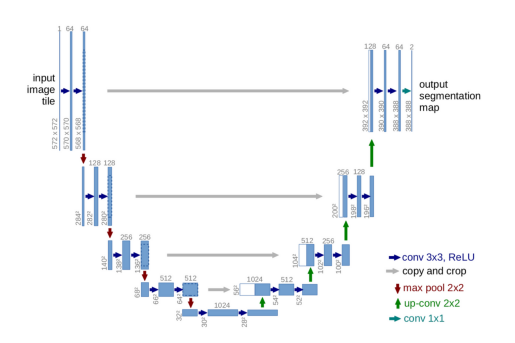

In [62]:
# Lire l'image
image = mpimg.imread(chemin_du_image_unet)

# Afficher l'image
plt.imshow(image)
plt.axis('off')
plt.show()

In [63]:
import random
import numpy as np
import torch

# Set seeds for reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Model configuration

In [64]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes

        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bridge = ConvBlock(512, 1024)

        self.dec4 = DecoderBlock(1024, 512, 512)
        self.dec3 = DecoderBlock(512, 256, 256)
        self.dec2 = DecoderBlock(256, 128, 128)
        self.dec1 = DecoderBlock(128, 64, 64)

        self.outconv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        b1 = self.bridge(p4)

        d4 = self.dec4(b1, s4)
        d3 = self.dec3(d4, s3)
        d2 = self.dec2(d3, s2)
        d1 = self.dec1(d2, s1)

        output = self.outconv(d1)
        return output


In [65]:
# Obtenir un batch d'images à partir du DataLoader d'entraînement
batch_images, batch_masks = next(iter(train_loader))

# Obtenir la forme des images d'entrée
IMG_HEIGHT = batch_images.shape[2]
IMG_WIDTH = batch_images.shape[3]
IMG_CHANNELS = batch_images.shape[1]
input_shape = (IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)

# Nombre de classes (segmentation binaire)
n_classes = 1

print("IMG_HEIGHT:", IMG_HEIGHT)
print("IMG_WIDTH:", IMG_WIDTH)
print("IMG_CHANNELS:", IMG_CHANNELS)
print("input_shape:", input_shape)
print("n_classes:", n_classes)


IMG_HEIGHT: 256
IMG_WIDTH: 256
IMG_CHANNELS: 3
input_shape: (3, 256, 256)
n_classes: 1


We can do a quick check to confirm the batch size, input shape, and output shape.

In [66]:
# Obtenir un batch d'images et de masques à partir du DataLoader d'entraînement
batch_images, batch_masks = next(iter(train_loader))

# Vérifier la taille du batch
batch_size = batch_images.shape[0]
print("Batch size:", batch_size)


Batch size: 16


In [67]:
# sanity check
input_shape #input shape

(3, 256, 256)

In [68]:
# Obtenir un batch d'images et de masques à partir du DataLoader d'entraînement
batch_images, batch_masks = next(iter(train_loader))

# Vérifier la forme des masques
target_shape = batch_masks.shape[1:]
print("Target shape:", target_shape)


Target shape: torch.Size([1, 256, 256])


In order to successfully compile the model, we will need to input the optimizer, loss function, and metrics correctly. We will use the typical Accuracy metric which calculates how often the predictions equal labels, and experiment with different combinations of optimizer (Adam and Nadam) and loss (Binary Crossentropy, Dice Loss, and IoU Loss) functions.

In [69]:
# Choisir un optimiseur
lr = 1e-4
adam_optimizer = optim.Adam(model.parameters(), lr=lr)
nadam_optimizer = optim.NAdam(model.parameters(), lr=lr)

# Choisir une fonction de perte
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)
    intersection = (y_true_flat * y_pred_flat).sum()
    return (2.0 * intersection + smooth) / (y_true_flat.sum() + y_pred_flat.sum() + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_coefficient(y_true, y_pred, smooth=1):
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)
    intersection = (y_true_flat * y_pred_flat).sum()
    union = y_true_flat.sum() + y_pred_flat.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def iou_loss(y_true, y_pred):
    return 1 - iou_coefficient(y_true, y_pred)

# Exemple d'utilisation : binary cross entropy loss
criterion = nn.BCEWithLogitsLoss()

# Exemple d'utilisation : dice loss
# criterion = dice_loss

# Exemple d'utilisation : iou loss
# criterion = iou_loss


NameError: name 'model' is not defined

In [70]:
# Créer une instance du modèle UNet
model = UNet(in_channels=3, n_classes=1)  # 3 canaux d'entrée pour des images RGB, 1 classe pour la segmentation binaire

# Afficher l'architecture du modèle
print(model)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss pour la segmentation binaire
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimiseur Adam avec un taux d'apprentissage de 0.001

# Afficher les paramètres du modèle
for name, param in model.named_parameters():
    print(name, param.shape)

# Mettre le modèle en mode d'entraînement
model.train()


UNet(
  (enc1): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

UNet(
  (enc1): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(skip_channels + out_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes

        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bridge = ConvBlock(512, 1024)

        self.dec4 = DecoderBlock(1024, 512, 512)
        self.dec3 = DecoderBlock(512, 256, 256)
        self.dec2 = DecoderBlock(256, 128, 128)
        self.dec1 = DecoderBlock(128, 64, 64)

        self.outconv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        b1 = self.bridge(p4)

        d4 = self.dec4(b1, s4)
        d3 = self.dec3(d4, s3)
        d2 = self.dec2(d3, s2)
        d1 = self.dec1(d2, s1)

        output = self.outconv(d1)
        return output

# Créer une instance du modèle UNet
model = UNet(in_channels=3, n_classes=1)  # 3 canaux d'entrée pour des images RGB, 1 classe pour la segmentation binaire

# Afficher l'architecture du modèle
print(model)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss pour la segmentation binaire
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimiseur Adam avec un taux d'apprentissage de 0.001

# Afficher les paramètres du modèle
for name, param in model.named_parameters():
    print(name, param.shape)

# Mettre le modèle en mode d'entraînement
model.train()

# Afficher le résumé du modèle
summary(model, input_size=(3, 256, 256))  # Input size: (batch_size, channels, height, width)


UNet(
  (enc1): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

Model training

In [ ]:
'''import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set parameters for training
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Utilize CUDA if available

# Set up the optimizer, criterion, and data loaders
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss for binary segmentation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Set up callbacks for model checkpoints, early stopping, and learning rate reduction
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

# Train the model
model.to(device)  # Move the model to the appropriate device (GPU or CPU)

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"Train Loss: {train_loss:.4f}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # No need to compute gradients during validation
        for inputs, labels in tqdm(valid_loader, desc=f"Validation {epoch + 1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss

            val_loss += loss.item()

    val_loss /= len(valid_loader)

    print(f"Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break

# Save the trained model
torch.save(model.state_dict(), 'unet.pth')'''


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set parameters for training
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Utilize CUDA if available

# Set up the optimizer, criterion, and data loaders
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss for binary segmentation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Set up callbacks for model checkpoints, early stopping, and learning rate reduction
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

# Train the model
model.to(device)  # Move the model to the appropriate device (GPU or CPU)



for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        train_loss += loss.item()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.numel()

    train_loss /= len(train_loader)
    train_accuracy = correct_predictions / total_predictions

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for inputs, labels in tqdm(valid_loader, desc=f"Validation {epoch + 1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss

            val_loss += loss.item()

            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.numel()

    val_loss /= len(valid_loader)
    val_accuracy = correct_predictions / total_predictions

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping!")
        break

# Save the trained model
torch.save(model.state_dict(), 'unet.pth')


Epoch 1/10:  64%|██████▍   | 32/50 [1:17:08<42:40, 142.26s/it]

In [ ]:
import matplotlib.pyplot as plt

# Get the history of accuracy and loss during training
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Train the model
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        # Compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss

            # Compute validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_loss += loss.item()

    val_losses.append(val_loss / len(valid_loader))
    val_accuracies.append(val_correct / val_total)

# Plot the accuracy and loss
plt.figure(figsize=(12, 5))

# Plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


**Evaluate Trained U-Net Model**
Other than accuracy, the other metrics that are often used in evaluating segmentation performance are:

Precision
Recall
IoU (Intersection over Union)
Dice Coefficient
The metric value ranges of all presented metrics span from 0 (worst) to 1 (best), and we will talk about each metrics in detail in the upcoming sections, now let's first load our trained model.

In [ ]:
import torch

# Define the path to the saved model
saved_model_path = './model/unet.pth'

# Load the saved model
loaded_model = UNet(in_channels=3, n_classes=1)  # Assuming the model architecture is defined in the UNet class
loaded_model.load_state_dict(torch.load(saved_model_path))

# Set the model to evaluation mode
loaded_model.eval()

**Confusion matrix**All presented metrics above are based on the computation of a confusion matrix, which represent the number of pixels that were correctly or incorrectly classified as either the object of interest or the background.

Let's conduct a confusion matrix and see how the U-Net model performs on test set

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming test_image and test_mask are torch tensors
# You might need to convert them to numpy arrays if they are not already numpy arrays
# Generate predictions for the test image
with torch.no_grad():
    loaded_model.eval()  # Set the model to evaluation mode
    test_image = test_image.to(device)  # Move data to the appropriate device if using GPU
    prediction = loaded_model(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).cpu().numpy().astype(np.uint8)  # Convert to numpy array

# Convert masks to 1D arrays and flatten them
test_mask_flat = test_mask.cpu().numpy().ravel()
binary_prediction_flat = binary_prediction.ravel()

# Convert binary masks to binary labels (0 or 1)
test_mask_labels = (test_mask_flat > 0).astype(np.uint8)
binary_prediction_labels = (binary_prediction_flat > 0).astype(np.uint8)

# Create the confusion matrix
conf_mat = confusion_matrix(test_mask_labels, binary_prediction_labels)
print(conf_mat)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Background", "Foreground"], yticklabels=["Background", "Foreground"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
